In [1]:
import sys

sys.path.append('/root/autodl-tmp/I-AM/project/backend/agents')

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages

from typing import List, Optional, Dict, Any, Literal
from pydantic import BaseModel, Field, ConfigDict, field_validator

import json
import yaml
from datetime import datetime
import os
from dotenv import load_dotenv

load_dotenv("/root/autodl-tmp/I-AM/project/backend/.env")

True

In [2]:
with open('/root/autodl-tmp/I-AM/project/backend/config/meditation.yaml', 'r') as f:
    meditation_config = yaml.safe_load(f)

In [3]:
def get_llm(model_type: str = "qwen2.5", **kwargs):
    """直接获取 LLM 模型实例"""
    
    # 默认参数
    default_params = {
        "temperature": 0.9,
        "max_tokens": 4096
    }
    # 合并用户传入的参数
    params = {**default_params, **kwargs}
    
    if model_type == "deepseek":
        return ChatOpenAI(
            model="deepseek-chat",
            openai_api_key=os.getenv("DEEPSEEK_API_KEY"),
            openai_api_base='https://api.deepseek.com',
            **params
        )
    elif model_type == "qwen2.5":
        return ChatOpenAI(
            model="qwen2.5",
            api_key="EMPTY",
            base_url=os.getenv("QWEN2.5_API_BASE"),
        )
    elif model_type == "tongyi":
        return ChatOpenAI(
            model=os.getenv("TONGYI_MODEL"),
            api_key=os.getenv("TONGYI_API_KEY"),
            base_url=os.getenv("TONGYI_API_BASE"),
        )

    else:
        raise ValueError(f"不支持的模型类型: {model_type}")

In [4]:
llm = get_llm(model_type="tongyi")

In [5]:
def add_log(current_log, new_log: str) -> list[str]:
    if current_log is None:
        return [new_log]
    elif isinstance(current_log, list):
        return current_log + [new_log]
    elif isinstance(current_log, str):
        return [current_log, new_log]
    else:
        return [new_log]

class OverallState(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)

    messages: List[AnyMessage] = Field(default_factory=list, title="对话列表")
    route: Literal["diary", "meditation", "normal_chat"] = Field(default="normal_chat", title="当前路由")
    log: List[str] = Field(default_factory=list, title="日志列表")

    @field_validator('log', mode='before')
    def validate_log(cls, v, info):
        if v is None or (isinstance(v, list) and len(v) == 0):
            return []
        if 'log' in info.data:
            return add_log(info.data['log'], v)
        return [v] if isinstance(v ,str) else v
        

    @field_validator('messages', mode='before')
    def validate_messages(cls, v, info):
        if 'messages' in info.data:
            return add_messages(info.data['messages'], v)
        else:
            return v if isinstance(v, list) else [v]

## 统一的结果状态类

In [6]:
class NodeResult(OverallState):
    local_route: Literal["outline_node", "script_node", "tone_marking_node", "tts_node"] = Field(default="outline_node", title="本地路由")
    success: bool = Field(default=True, title="执行状态")
    data: Optional[Dict[str, Any]] = Field(default=None, title="详细传递数据")
    error: Optional[str] = Field(default=None, title="错误信息")

## Outline Node

In [7]:
# 定义冥想类型枚举
class MeditationType(BaseModel):
    category: Literal["breathing", "visualization", "body_scan", "gratitude", "affirmation", "mindfulness"] = Field(..., title="冥想类型")
    duration_minutes: int = Field(..., title="预期时长(分钟)", ge=1, le=30)
    background_music_style: Optional[str] = Field(None, title="背景音乐风格偏好")

# 定义用户意图模型
class UserIntent(BaseModel):
    goal: str = Field(..., title="用户的目标或需求")
    current_mood: Optional[str] = Field(None, title="当前情绪状态")
    preferences: Optional[Dict[str, Any]] = Field(default_factory=dict, title="特殊偏好")

# 定义确定内容模型
class DefiniteContent(BaseModel):
    content: str = Field(..., title="具体内容")
    context: Optional[str] = Field(None, title="相关上下文")

# 定义内容段落模型
class ContentBlock(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    purpose: str = Field(..., title="段落目的")
    key_elements: List[str] = Field(..., title="关键要素")
    tone: Optional[str] = Field(None, title="语气特点")
    timing: Optional[str] = Field(None, title="时间控制建议")
    
    # 确定要包含的内容列表（可选）
    definite_contents: Optional[List[DefiniteContent]] = Field(
        default=None, 
        title="确定要包含的内容"
    )

    def add_content(self, content: str, context: Optional[str] = None) -> None:
        """添加确定要包含的内容"""
        if self.definite_contents is None:
            self.definite_contents = []
        self.definite_contents.append(
            DefiniteContent(
                content=content,
                context=context
            )
        )
        
    # 内容在段落中的放置位置
    content_placement: Literal["start", "middle", "end", "flexible"] = Field(
        default="flexible",
        title="内容放置位置"
    )
    # 内容整合的相关说明
    integration_notes: Optional[str] = Field(
        None, 
        title="内容整合建议"
    )

    @property
    def has_definite_content(self) -> bool:
        """检查是否包含确定内容"""
        return self.definite_contents is not None and len(self.definite_contents) > 0

    def add_content(self, content: str, context: Optional[str] = None) -> None:
        """添加确定要包含的内容"""
        if self.definite_contents is None:
            self.definite_contents = []
        self.definite_contents.append(
            DefiniteContent(
                content=content,
                context=context
            )
        )

# 定义完整冥想大纲
class MeditationOutline(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    meditation_type: MeditationType = Field(..., title="冥想类型配置")
    user_intent: UserIntent = Field(..., title="用户意图")
    content_blocks: List[ContentBlock] = Field(..., title="内容块列表")
    special_instructions: Optional[List[str]] = Field(default_factory=list, title="特殊指示")

    @property
    def as_str(self) -> str:
        """将大纲转换为字符串格式"""
        # 构建冥想类型信息
        meditation_info = (
            f"# 冥想配置\n\n"
            f"- 类型：{self.meditation_type.category}\n"
            f"- 时长：{self.meditation_type.duration_minutes}分钟\n"
            f"- 音乐风格：{self.meditation_type.background_music_style or '默认'}\n\n"
        )
        
        # 构建用户意图信息
        intent_info = (
            f"# 用户意图\n\n"
            f"- 目标：{self.user_intent.goal}\n"
            f"- 当前情绪：{self.user_intent.current_mood or '未指定'}\n"
            f"- 特殊偏好：{', '.join(f'{k}: {v}' for k, v in self.user_intent.preferences.items()) or '无'}\n\n"
        )
        
        # 构建内容块信息
        content_info = "# 内容结构\n\n"
        for i, block in enumerate(self.content_blocks, 1):
            content_info += (
                f"## 内容块 {i}\n"
                f"目的：{block.purpose}\n"
                f"关键要素：{', '.join(block.key_elements)}\n"
                f"语气：{block.tone or '自然'}\n"
                f"时间：{block.timing or '灵活'}\n"
            )
            
            # 添加确定内容的信息
            if block.has_definite_content:
                content_info += "\n确定内容：\n"
                for content in block.definite_contents:
                    content_info += (
                        f"- {content.content}\n"
                        f"  上下文：{content.context or '无'}\n"
                    )
            
            if block.integration_notes:
                content_info += f"\n整合建议：{block.integration_notes}\n"
            
            content_info += f"\n放置位置：{block.content_placement}\n\n"
        
        # 添加特殊指示
        if self.special_instructions:
            content_info += (
                f"# 特殊指示\n\n"
                f"{chr(10).join(f'- {instruction}' for instruction in self.special_instructions)}"
            )
        
        return meditation_info + intent_info + content_info

with open(meditation_config['prompts']['outline'], 'r', encoding='utf-8') as f:
    MEDITATION_OUTLINE_PROMPT = f.read()


async def create_meditation_outline(state: NodeResult, config) -> NodeResult:
    try:
        conversation_content = ""
        for message in state.messages:
            if isinstance(message, HumanMessage):
                conversation_content += f"user: {message.content}\n"
            elif isinstance(message, AIMessage):
                conversation_content += f"assistant: {message.content}\n"
            else:
                continue
        meditation_outline_prompt = ChatPromptTemplate([
            ("system", MEDITATION_OUTLINE_PROMPT),
            ("user", "{conversation_content}")
        ])
        generate_meditation_outline = meditation_outline_prompt | llm.with_structured_output(MeditationOutline, method="function_calling")
        outline = await generate_meditation_outline.ainvoke({"conversation_content": conversation_content}, config)

        timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        output_path = f"{meditation_config['paths']['outline_output_path']}/{timestamp}.txt"
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(outline.as_str)

        print("大纲已生成")
        
        return NodeResult(local_route="outline_node", data={"outline": outline.as_str})
    except Exception as e:
        return NodeResult(local_route="outline_node", success=False, error=str(e), log=f"大纲生成失败: {str(e)}")

## Script Node

In [8]:

class MeditationScript(BaseModel):
    sequences: List[str] = Field(..., title="引导词序列")

    @property
    def as_str(self) -> str:
        return "\n\n".join(
            f"text: {item}"
            for item in self.sequences
        )

    @property
    def as_yaml(self) -> str:
        return "sequences:\n" + "\n".join(
            f"id: {idx}\ntext: {item}"
            for idx, item in enumerate(self.sequences)
        )

with open(meditation_config['prompts']['script'], 'r', encoding='utf-8') as f:
    MEDITATION_SCRIPT_PROMPT = f.read()


async def create_meditation_script(state: NodeResult, config) -> NodeResult:
    try:
        script_prompt = ChatPromptTemplate.from_messages([
            ("system", MEDITATION_SCRIPT_PROMPT),
            ("user", """请根据以下冥想大纲生成详细的引导词：

        {outline}""")
        ])
        generate_meditation_script = script_prompt | llm.with_structured_output(MeditationScript, method="function_calling")
        script = await generate_meditation_script.ainvoke({"outline": state.data['outline']}, config)

        print("脚本已生成")
        
        return NodeResult(local_route="script_node", data={"script": script.as_str})
    except Exception as e:
        return NodeResult(local_route="script_node", success=False, error=str(e), log=f"脚本生成失败: {str(e)}")


## Tone Marking Node

In [9]:

# 定义带标记的文本段落
class MarkedSequence(BaseModel):
    original_text: str = Field(..., title="原始文本")
    marked_text: str = Field(..., title="带标记的文本")
    duration: int = Field(..., title="持续时间（秒）", ge=2, le=6)

# 定义完整的带标记冥想脚本
class MarkedMeditationScript(BaseModel):
    sequences: List[MarkedSequence] = Field(..., title="带标记的引导词序列")

    @property
    def as_str(self) -> str:
        return "\n\n".join(
            f"id: {idx}\ntext: {item.marked_text}\nduration: {item.duration}"
            for idx, item in enumerate(self.sequences)
        )
    
    @property
    def as_yaml(self) -> str:
        return "sequences:\n" + "\n".join(
            f"id: {idx}\ntext: \"{item.marked_text}\"\nduration: {item.duration}"
            for idx, item in enumerate(self.sequences)
        )

    def to_yaml_dict(self) -> dict:
        return {
            "sequences": [
                {
                    "id": idx,
                    "text": item.marked_text,
                    "duration": item.duration
                }
                for idx, item in enumerate(self.sequences)
            ]
        }

with open(meditation_config['prompts']['tone'], 'r', encoding='utf-8') as f:
    MEDITATION_TONE_PROMPT = f.read()



async def create_marked_meditation_script(state: NodeResult, config) -> NodeResult:
    try:
        tone_marking_prompt = ChatPromptTemplate.from_messages([
            ("system", MEDITATION_TONE_PROMPT),
            ("user", "请为以下冥想引导词添加适当的语气标记：\n\n{script}")
        ])
        generate_marked_script = tone_marking_prompt | llm.with_structured_output(MarkedMeditationScript, method="function_calling")
        marked_script = await generate_marked_script.ainvoke({"script": state.data['script']}, config)
        
        timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        output_path = f"{meditation_config['paths']['script_output_path']}/{timestamp}.yaml"
        with open(output_path, 'w', encoding='utf-8') as f:
            yaml.dump(marked_script.to_yaml_dict(), f, indent=2, allow_unicode=True, sort_keys=False)

        print("带标记的脚本已生成")
        
        return NodeResult(local_route="tone_marking_node", data=marked_script.to_yaml_dict())
    except Exception as e:
        return NodeResult(local_route="tone_marking_node", success=False, error=str(e), log=f"带标记的脚本生成失败: {str(e)}")



## tts Node

In [10]:
from meditation_tts import CosyVoice2TTS

def create_tts(state: NodeResult) -> NodeResult:
    try:
        timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        output_path = os.path.join(meditation_config['paths']['tts_output_path'], f"{timestamp}.wav")
        tts = CosyVoice2TTS(
            model_path=meditation_config['tts']['tts_model_path'],
            prompts_config_path=meditation_config['tts']['tts_resources_config']
        )
        tts.generate_audio(
            texts=state.data,
            voice_type="female1",
            background_music_type="bmusic_02",
            output_path=output_path
        )  

        print("音频已生成")
        
        return NodeResult(local_route="tts_node", log=f"音频已生成. path: {output_path}")
    except Exception as e:
        return NodeResult(local_route="tts_node", success=False, error=str(e), log=f"音频生成失败: {str(e)}")


2025-05-07 20:21:18,457 - modelscope - INFO - PyTorch version 2.6.0 Found.
2025-05-07 20:21:18,458 - modelscope - INFO - Loading ast index from /root/.cache/modelscope/ast_indexer
2025-05-07 20:21:18,623 - modelscope - INFO - Loading done! Current index file version is 1.15.0, with md5 2f5eeacd95c207bb2bc0f708cda0b4fd and a total number of 980 components indexed
/root/miniconda3/envs/manifest_app/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


failed to import ttsfrd, use WeTextProcessing instead


## 错误处理节点

In [11]:
def handle_error(state: NodeResult) -> NodeResult:  # 修改返回类型标注
    error_msg = state.error
    print(f"处理错误: {error_msg}")
    # 返回正确的 NodeResult 对象
    return NodeResult(
        success=False,
        error=error_msg,
        data={"error_message": f"处理错误: {error_msg}"}
    )

## 条件边判断

In [12]:
def check_success(state: NodeResult):
    if state.success:
        return "success_node"
    else:
        return "error_node"


In [13]:
meditation_workflow = StateGraph(NodeResult)
meditation_workflow.add_node("outline_node", create_meditation_outline)
meditation_workflow.add_node("script_node", create_meditation_script)
meditation_workflow.add_node("tone_marking_node", create_marked_meditation_script)
meditation_workflow.add_node("tts_node", create_tts)
meditation_workflow.add_node("error_node", handle_error)

meditation_workflow.add_conditional_edges(
    "outline_node",
    check_success,
    {
        "success_node": "script_node",
        "error_node": "error_node"
    }
)

meditation_workflow.add_conditional_edges(
        "script_node",
        check_success,
        {
            "success_node": "tone_marking_node",
            "error_node": "error_node"
        }
    )
    
meditation_workflow.add_conditional_edges(
    "tone_marking_node",
    check_success,
    {
        "success_node": "tts_node",
        "error_node": "error_node"
    }
)

meditation_workflow.add_conditional_edges(
    "tts_node",
    check_success,
    {
        "success_node": END,
        "error_node": "error_node"
    }
)
meditation_workflow.add_edge(START, "outline_node")
meditation_workflow.add_edge("error_node", END)

meditation_graph = meditation_workflow.compile(checkpointer=MemorySaver())

2025-05-07 20:21:26,881 DEBUG Starting new HTTPS connection (1): mermaid.ink:443
2025-05-07 20:21:28,122 DEBUG https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCW91dGxpbmVfbm9kZShvdXRsaW5lX25vZGUpCglzY3JpcHRfbm9kZShzY3JpcHRfbm9kZSkKCXRvbmVfbWFya2luZ19ub2RlKHRvbmVfbWFya2luZ19ub2RlKQoJdHRzX25vZGUodHRzX25vZGUpCgllcnJvcl9ub2RlKGVycm9yX25vZGUpCglfX2VuZF9fKFs8cD5fX2VuZF9fPC9wPl0pOjo6bGFzdAoJX19zdGFydF9fIC0tPiBvdXRsaW5lX25vZGU7CgllcnJvcl9ub2RlIC0tPiBfX2VuZF9fOwoJb3V0bGluZV9ub2RlIC0uICZuYnNwO3N1Y2Nlc3Nfbm9kZSZuYnNwOyAuLT4gc2NyaXB0X25vZGU7CglvdXRsaW5lX25vZGUgLS4tPiBlcnJvcl9ub2RlOwoJc2NyaXB0X25vZGUgLS4gJm5ic3A7c3VjY2Vzc19ub2RlJm5ic3A7IC4tPiB0b25lX21hcmtpbmdfbm9kZTsKCXNjcmlwdF9ub2RlIC0uLT4gZXJyb3Jfbm9kZTsKCXRvbmVfbWFya2luZ19ub2RlIC0uICZuYnNwO3N1Y2Nlc3Nfbm9kZSZuYnNwOyAuLT4gdHRzX25vZGU7Cgl0b25lX21hcmtpbmdfbm9kZSAtLi0+IGVycm9yX25vZGU7Cgl0dHNfbm9kZSAtLiAmbmJzcDtzdWNjZXNzX25vZGUmbmJzcDsgLi0

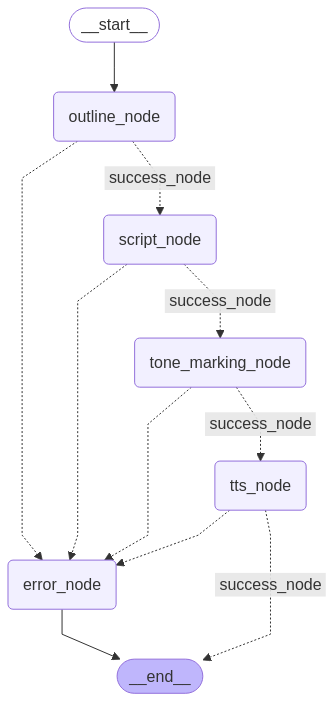

In [14]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(meditation_graph.get_graph(xray=2).draw_mermaid_png()))

In [15]:
messages = [HumanMessage(content='我下周要去面试，我好紧张，请帮我生成一些肯定语，让我充满信心', additional_kwargs={}, response_metadata={}, id='0cb98d68-fcc4-43d3-b309-be8bcb0f3237'),
 AIMessage(content='太棒了！你已经迈出了重要的一步，准备去面试了！🌟 紧张是很正常的，但我们可以通过一些肯定语来帮助你增强信心。以下是一些为你量身定制的肯定语：\n\n1. **我充满自信地迎接下周的面试，展现出最好的自己。**\n2. **我准备充分，轻松应对面试中的每一个问题。**\n3. **我的能力和经验让我在面试中脱颖而出。**\n4. **我保持冷静和专注，展现出我的专业素养。**\n5. **面试官对我的表现印象深刻，我顺利通过了面试。**\n\n这些肯定语可以帮助你在面试前和面试中保持积极的心态。你可以每天早晨起床后和晚上睡觉前重复这些肯定语，也可以在镜子前大声说出来，增强你的自信感。\n\n你觉得这些肯定语对你有帮助吗？或者你还有其他方面的需求吗？😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 173, 'prompt_tokens': 597, 'total_tokens': 770, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'prompt_cache_hit_tokens': 512, 'prompt_cache_miss_tokens': 85}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4', 'finish_reason': 'stop', 'logprobs': None}, id='run-0736423a-4921-4fea-bd56-2e535239e62a-0', usage_metadata={'input_tokens': 597, 'output_tokens': 173, 'total_tokens': 770, 'input_token_details': {}, 'output_token_details': {}}),
 HumanMessage(content='该如何使用这些肯定语？', additional_kwargs={}, response_metadata={}, id='56af430e-cce7-409d-8869-69ee88f80415'),
 AIMessage(content='使用肯定语是一种非常有效的自我激励和情绪调节方法。以下是一些具体的使用建议，帮助你更好地利用这些肯定语：\n\n1. **早晨和晚上重复**：\n   - 每天早晨起床后，花几分钟时间，闭上眼睛，深呼吸，然后逐句重复这些肯定语。想象自己正在面试中，自信满满地回答问题。\n   - 晚上睡觉前，再次重复这些肯定语，帮助你在潜意识中巩固这些积极的想法。\n\n2. **镜子练习**：\n   - 站在镜子前，看着自己的眼睛，逐句大声说出这些肯定语。这种练习可以帮助你增强自信，并让你更直观地感受到自己的变化。\n\n3. **写在便签上**：\n   - 将这些肯定语写在便签上，贴在你经常能看到的地方，比如浴室镜子、电脑屏幕旁或冰箱门上。每次看到这些便签，就默念或大声读出来。\n\n4. **冥想结合**：\n   - 在进行冥想时，可以将这些肯定语作为冥想的一部分。在冥想过程中，想象自己正在面试，感受到自信和从容。\n\n5. **日常提醒**：\n   - 在手机或电脑上设置提醒，每天定时提醒你重复这些肯定语。这样可以帮助你在忙碌的日常中不忘保持积极的心态。\n\n6. **情绪调节**：\n   - 当你感到紧张或不安时，立即停下来，深呼吸几次，然后默念这些肯定语。这可以帮助你迅速调整情绪，恢复平静。\n\n你觉得这些方法中哪一种最适合你？或者你有其他想法吗？😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 316, 'prompt_tokens': 788, 'total_tokens': 1104, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'prompt_cache_hit_tokens': 512, 'prompt_cache_miss_tokens': 276}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4', 'finish_reason': 'stop', 'logprobs': None}, id='run-1fa09ff5-0fc1-47b0-ba8c-17764fe82dc0-0', usage_metadata={'input_tokens': 788, 'output_tokens': 316, 'total_tokens': 1104, 'input_token_details': {}, 'output_token_details': {}}),
 HumanMessage(content='很好，可以将这些肯定语和使用方法，组织成一个冥想音频吗？方便我随时听', additional_kwargs={}, response_metadata={}, id='ecd86479-26c0-43ff-b937-13d359813965')]

In [16]:
import json
from uuid import uuid4

thread = {"configurable": {"thread_id": str(uuid4())}}

async for event in meditation_graph.astream(NodeResult(messages=messages), config=thread, stream_mode="updates"):
    print("!!!", event, "!!!")

2025-05-07 20:21:30,260 DEBUG Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': '你是一位专业的冥想引导师，现在需要你根据用户的对话内容，生成一个冥想引导词的结构化大纲。\n\n请遵循以下要求：\n\n1. 分析用户对话内容，提取以下信息：\n   - 用户的目标或需求\n   - 当前的情绪状态（如有）\n   - 特殊偏好（如语速、音乐等，如有）\n   - 冥想时长（如未指定，默认为5分钟）\n   - 对话中提到的希望包含的具体内容或表达\n\n2. 确定合适的冥想类型：\n   - breathing（呼吸冥想）\n   - visualization（视觉化冥想）\n   - body_scan（身体扫描）\n   - gratitude（感恩冥想）\n   - affirmation（肯定语冥想）\n   - mindfulness（正念冥想）\n\n3. 生成一个 JSON 格式的冥想脚本大纲\n\n注意事项：\n1. content_blocks 的数量和结构应根据冥想类型和时长灵活安排，不必遵循固定模式\n2. 如果在对话中发现用户特别提到或认可的表达方式，应将其添加到相应 content_block 的 definite_contents 中\n3. 每个 content_block 的时长分配要合理，总和应等于预期时长\n4. 根据用户的情绪状态和目标选择适当的语气和引导节奏\n\n请根据用户的对话内容，生成一个适合的冥想引导大纲。', 'role': 'system'}, {'content': 'user: 我下周要去面试，我好紧张，请帮我生成一些肯定语，让我充满信心\nassistant: 太棒了！你已经迈出了重要的一步，准备去面试了！🌟 紧张是很正常的，但我们可以通过一些肯定语来帮助你增强信心。以下是一些为你量身定制的肯定语：\n\n1. **我充满自信地迎接下周的面试，展现出最好的自己。**\n2. **我准备充分，轻松应对面试中的每一个问题。**\n3. **我的能力和经验让我在面试中脱颖而出。**\n4. **我保持

大纲已生成
!!! {'outline_node': {'messages': [], 'route': 'normal_chat', 'log': [], 'local_route': 'outline_node', 'success': True, 'data': {'outline': '# 冥想配置\n\n- 类型：affirmation\n- 时长：5分钟\n- 音乐风格：默认\n\n# 用户意图\n\n- 目标：增强面试前的信心\n- 当前情绪：紧张\n- 特殊偏好：music_preference: 轻柔背景音乐, voice_tone: 温暖而鼓励, speech_rate: 适中偏慢\n\n# 内容结构\n\n## 内容块 1\n目的：引导用户放松并进入冥想状态\n关键要素：深呼吸, 放松肌肉, 集中注意力\n语气：温和\n时间：1分钟\n\n确定内容：\n- 现在找一个舒适的位置坐下或躺下，闭上眼睛，深深地吸一口气，慢慢地呼出。感受每一次呼吸带来的平静。\n  上下文：引导用户开始放松\n\n放置位置：flexible\n\n## 内容块 2\n目的：介绍肯定语及其作用\n关键要素：肯定语的力量, 提升自信心\n语气：鼓励\n时间：1分钟\n\n确定内容：\n- 接下来我们将一起探索肯定语的力量，它们可以帮助我们在面对挑战时保持自信和平静。\n  上下文：解释肯定语的作用\n\n放置位置：flexible\n\n## 内容块 3\n目的：重复肯定语\n关键要素：肯定语列表, 内心默念\n语气：温暖\n时间：2分钟\n\n确定内容：\n- 现在，让我们一起重复以下这些肯定语，每次重复时，感受它们带给你内心的平静和力量。\n  上下文：指导用户重复肯定语\n\n放置位置：flexible\n\n## 内容块 4\n目的：结束冥想\n关键要素：感谢参与, 鼓励继续实践肯定语\n语气：温暖\n时间：1分钟\n\n确定内容：\n- 感谢你今天的参与，记得每天都可以重复这些肯定语，无论是在早晨还是睡前，或是任何你觉得需要的时候。\n  上下文：结束冥想，鼓励持续实践\n\n放置位置：flexible\n\n# 特殊指示\n\n- 使用轻柔背景音乐\n- 语速适中偏慢\n- 语气温暖而鼓励'}}} !!!


2025-05-07 20:21:43,492 DEBUG receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'vary', b'Origin,Access-Control-Request-Method,Access-Control-Request-Headers, Accept-Encoding'), (b'x-request-id', b'53d6b93b-1fe5-9aab-85c5-9351de34d031'), (b'x-dashscope-call-gateway', b'true'), (b'content-type', b'application/json'), (b'req-cost-time', b'3556'), (b'req-arrive-time', b'1746620499911'), (b'resp-start-time', b'1746620503468'), (b'x-envoy-upstream-service-time', b'3554'), (b'content-encoding', b'gzip'), (b'date', b'Wed, 07 May 2025 12:21:43 GMT'), (b'server', b'istio-envoy'), (b'transfer-encoding', b'chunked')])
2025-05-07 20:21:43,493 INFO HTTP Request: POST https://dashscope.aliyuncs.com/compatible-mode/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:21:43,494 DEBUG receive_response_body.started request=<Request [b'POST']>
2025-05-07 20:21:43,496 DEBUG receive_response_body.complete
2025-05-07 20:21:43,497 DEBUG response_closed.started
2025-05-07 20:21:43,498

脚本已生成
!!! {'script_node': {'messages': [], 'route': 'normal_chat', 'log': [], 'local_route': 'script_node', 'success': True, 'data': {'script': 'text: 现在找一个舒适的位置坐下或躺下，闭上眼睛，深深地吸一口气，慢慢地呼出。感受每一次呼吸带来的平静。\n\ntext: 接下来我们将一起探索肯定语的力量，它们可以帮助我们在面对挑战时保持自信和平静。\n\ntext: 现在，让我们一起重复以下这些肯定语，每次重复时，感受它们带给你内心的平静和力量。\n\ntext: 感谢你今天的参与，记得每天都可以重复这些肯定语，无论是在早晨还是睡前，或是任何你觉得需要的时候。'}}} !!!


2025-05-07 20:21:50,257 DEBUG receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'vary', b'Origin,Access-Control-Request-Method,Access-Control-Request-Headers, Accept-Encoding'), (b'x-request-id', b'38eb6ee6-5d42-92c0-8aab-6e647ec532d8'), (b'x-dashscope-call-gateway', b'true'), (b'content-type', b'application/json'), (b'req-cost-time', b'6717'), (b'req-arrive-time', b'1746620503515'), (b'resp-start-time', b'1746620510233'), (b'x-envoy-upstream-service-time', b'6715'), (b'content-encoding', b'gzip'), (b'date', b'Wed, 07 May 2025 12:21:49 GMT'), (b'server', b'istio-envoy'), (b'transfer-encoding', b'chunked')])
2025-05-07 20:21:50,258 INFO HTTP Request: POST https://dashscope.aliyuncs.com/compatible-mode/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 20:21:50,259 DEBUG receive_response_body.started request=<Request [b'POST']>
2025-05-07 20:21:50,260 DEBUG receive_response_body.complete
2025-05-07 20:21:50,261 DEBUG response_closed.started
2025-05-07 20:21:50,261

带标记的脚本已生成
!!! {'tone_marking_node': {'messages': [], 'route': 'normal_chat', 'log': [], 'local_route': 'tone_marking_node', 'success': True, 'data': {'sequences': [{'id': 0, 'text': '现在找一个舒适的位置坐下或躺下，闭上眼睛，[breath]深深地吸一口气，慢慢地呼出。感受每一次呼吸带来的平静。', 'duration': 5}, {'id': 1, 'text': '接下来我们将一起探索肯定语的力量，它们可以帮助我们在面对挑战时<em>保持自信和平静。</em>', 'duration': 4}, {'id': 2, 'text': '现在，让我们一起重复以下这些肯定语，每次重复时，感受它们带给你内心的平静和力量[breath]。', 'duration': 5}, {'id': 3, 'text': '感谢你今天的参与，记得每天都可以重复这些肯定语，无论是在早晨还是睡前，或是任何你觉得需要的时候[breath]。', 'duration': 5}]}}} !!!


/root/miniconda3/envs/manifest_app/lib/python3.11/site-packages/diffusers/models/lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)
2025-05-07 20:21:54,878 INFO input frame rate=25
/root/miniconda3/envs/manifest_app/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/root/autodl-tmp/I-AM/CosyVoice/cosyvoice/dataset/processor.py:24: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend('soundfile')
Special tokens have been added in the vocabulary, make sure the as

Attempt 1 of 3


Generating audio segments:   0%|          | 0/4 [00:00<?, ?it/s]2025-05-07 20:22:02,956 INFO synthesis text 现在找一个舒适的位置坐下或躺下,闭上眼睛,[breath]深深地吸一口气,慢慢地呼出。感受每一次呼吸带来的平静。
2025-05-07 20:22:10,603 INFO yield speech len 14.24, rtf 0.536975683121199
Generating audio segments:  25%|██▌       | 1/4 [00:08<00:26,  8.82s/it]2025-05-07 20:22:11,746 INFO synthesis text 接下来我们将一起探索肯定语的力量,它们可以帮助我们在面对挑战时<em>保持自信和平静。</em>。
2025-05-07 20:22:20,813 INFO yield speech len 12.92, rtf 0.7017740524221131
Generating audio segments:  50%|█████     | 2/4 [00:19<00:19,  9.64s/it]2025-05-07 20:22:21,957 INFO synthesis text 现在,让我们一起重复以下这些肯定语,每次重复时,感受它们带给你内心的平静和力量[breath]。
2025-05-07 20:22:30,014 INFO yield speech len 11.28, rtf 0.7142202228519089
Generating audio segments:  75%|███████▌  | 3/4 [00:28<00:09,  9.44s/it]2025-05-07 20:22:31,162 INFO synthesis text 感谢你今天的参与,记得每天都可以重复这些肯定语,无论是在早晨还是睡前,或是任何你觉得需要的时候[breath]。
2025-05-07 20:22:40,192 INFO yield speech len 11.12, rtf 0.8121014498978211
Generating audio segments: 1

Combining audio segments with background music...
Saving final audio to /root/autodl-tmp/I-AM/project/backend/agents/output/meditation/tts/20250507202150.wav
Audio generation completed!
音频已生成
!!! {'tts_node': {'messages': [], 'route': 'normal_chat', 'log': ['音频已生成. path: /root/autodl-tmp/I-AM/project/backend/agents/output/meditation/tts/20250507202150.wav'], 'local_route': 'tts_node', 'success': True}} !!!
